# First tests with Fourier Domain Adaptation

## Requirements

In [1]:
import os
import sys
import json
import random
from pathlib import Path
sys.path.insert(0, os.path.join("..", "..", "src"))

import torch
import pyvips
import deeplake
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

'''from utils.constants import (
    RAW_DIR, 
    PATCH_DIR,
    ASSET_DIR,
    SEVERITY_COLOR_MAP
)'''

'''from utils import (
    img_transform_fn
)'''

'from utils import (\n    img_transform_fn\n)'

## Verification of the dataset

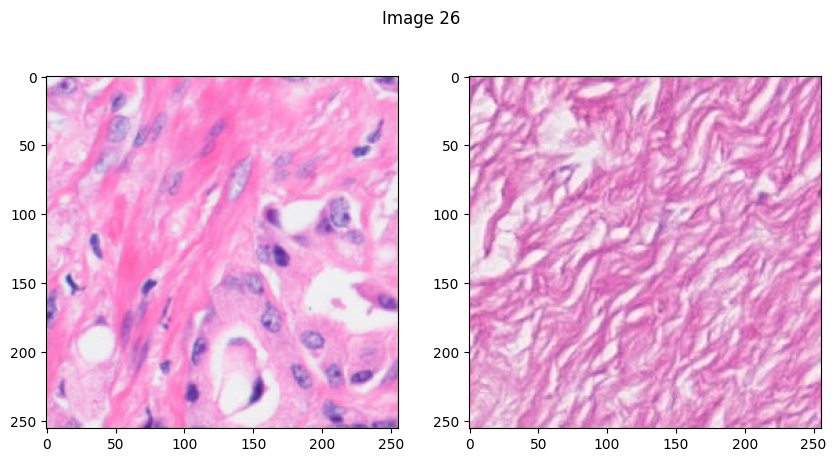

In [2]:
import time
from IPython.display import clear_output
#test automatique du bon fonctionnement du dataset
for i in range(1,25+1):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    dataset_path = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_Akoya"
    ds = deeplake.open_read_only(dataset_path)
    axes[0].imshow(ds[200]["patch"])
    #plt.show()
    dataset_path = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_KFBio"
    ds = deeplake.open_read_only(dataset_path)
    axes[1].imshow(ds[200]["patch"])
    plt.suptitle(f"Image {i+1}")
    plt.show()
    time.sleep(4)
    clear_output(wait=True)

## Visualisation of Akoya and unmodified KFBio

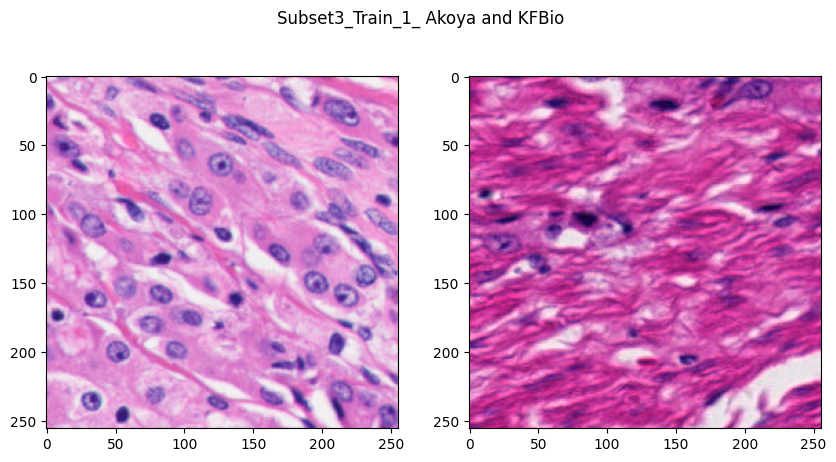

Akoya 1 shape: (256, 256, 3)


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
dataset_path_akoya_1 = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_Akoya"
akoya_1 = deeplake.open_read_only(dataset_path_akoya_1)
axes[0].imshow(akoya_1[200]["patch"])
#plt.show()
dataset_path_KFbio_1 = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_KFBio"
KFBio_1 = deeplake.open_read_only(dataset_path_KFbio_1)
axes[1].imshow(KFBio_1[200]["patch"])
plt.suptitle(f"Subset3_Train_1_ Akoya and KFBio")
plt.savefig("/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/akoya_vs_KFBio.svg")
plt.show()



#shape
print(f"Akoya 1 shape: {akoya_1[200]['patch'].shape}") #(256, 256, 3)

We can see that KFBio is much darker than Akoya, which resulted in worse performances.

## Global Fourier Domain Adaptation
Inspired from Yanchao Yang & Stefano Soatto 2020, git available at https://github.com/YanchaoYang/FDA.git

### Pairwise migration

Here, we try to make one KFBio image closer from one reference Akoya image using Fourier analysis.

Time taken for FDA: 0.030905723571777344 seconds


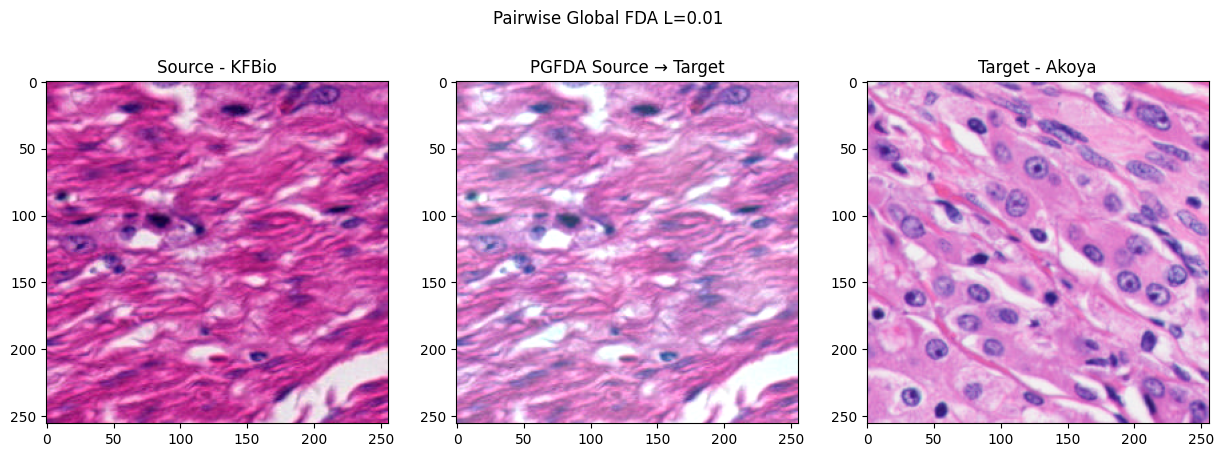

In [44]:
def extract_ampl_phase(fft_im):
    # fft_im: size should be bx3xhxwx2
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    fft_amp = torch.sqrt(fft_amp)
    fft_pha = torch.atan2( fft_im[:,:,:,:,1], fft_im[:,:,:,:,0] )
    return fft_amp, fft_pha

def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def FDA_source_to_target_np( src_img, trg_img, L=0.1 ):
    # exchange magnitude
    # input: src_img, trg_img

    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )

    # get the mutated image
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg


#Test
src_img = KFBio_1[200]["patch"].transpose((2, 0, 1))  # (3, 256, 256)
trg_img = akoya_1[200]["patch"].transpose((2, 0, 1))
L_hyperparam = 0.01 #float(input("Enter the L hyperparameter (e.g., 0.1): "))
start_time = time.time()
new_KFBio_1 = FDA_source_to_target_np( src_img, trg_img, L_hyperparam )
end_time = time.time()
print(f"Time taken for FDA: {end_time - start_time} seconds")   

#display
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(src_img.transpose((1, 2, 0)).astype(np.uint8))
axes[0].set_title("Source - KFBio")

axes[1].imshow(np.clip(new_KFBio_1, 0, 255).astype(np.uint8).transpose((1, 2, 0)))
axes[1].set_title("PGFDA Source → Target")

axes[2].imshow(trg_img.transpose((1, 2, 0)).astype(np.uint8))
axes[2].set_title("Target - Akoya")

plt.suptitle(f"Pairwise Global FDA L={L_hyperparam}")
plt.savefig(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/pairwise_global_FDA_L={L_hyperparam}.svg")




## Mean migration

As we are dealing with multiple patches from multiple images, it is important to know which reference we should select to migrate image. Here, we try to compute the average of the low frequencies from all patches from all images from Akoya scanner. 

Careful: this might be extremely slow, but once we have computed the average we can store this value and use is again later. 

In [63]:
#code for target amplitude
def target_amplitude(img):
    img = img.astype(np.float32)
    fft_img = np.fft.fft2(img, axes=(-2, -1))
    amplitude = np.abs(fft_img)
    return amplitude


big_sum = np.zeros((3, 256, 256))
total_patches = 0
#loop across WSIs
for i in range(1, 26 + 1):
    dataset_path_akoya = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_Akoya"
    akoya = deeplake.open_read_only(dataset_path_akoya)
    print("nb of patches = ", len(akoya))
    #loop across patches
    for j in range(len(akoya)):
        target_image = akoya[j]["patch"].transpose((2, 0, 1))
        amplitude = target_amplitude(target_image)
        big_sum += amplitude
        total_patches += 1

    #np.save(f"/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/average_amplitude_akoya_{i}.npy", average_amplitude)
    print(f"Average amplitude saved for image {i}.")

global_average = big_sum / total_patches
print("total_patches = ", total_patches)
np.save("/home/leolr-int/ASTAR_internship/Fourier_Domain_Adaptation/stored_amplitude/global_average_amplitude_akoya.npy", global_average)






nb of patches =  10675
Average amplitude saved for image 1.
nb of patches =  11743
Average amplitude saved for image 2.
nb of patches =  6010
Average amplitude saved for image 3.
nb of patches =  4756
Average amplitude saved for image 4.
nb of patches =  2313
Average amplitude saved for image 5.
nb of patches =  7413
Average amplitude saved for image 6.
nb of patches =  13560
Average amplitude saved for image 7.
nb of patches =  6534
Average amplitude saved for image 8.
nb of patches =  4822
Average amplitude saved for image 9.
nb of patches =  357
Average amplitude saved for image 10.
nb of patches =  3402
Average amplitude saved for image 11.
nb of patches =  17098
Average amplitude saved for image 12.
nb of patches =  4077
Average amplitude saved for image 13.
nb of patches =  5051
Average amplitude saved for image 14.
nb of patches =  3268
Average amplitude saved for image 15.
nb of patches =  12043
Average amplitude saved for image 16.
nb of patches =  6271
Average amplitude saved

ValueError: operands could not be broadcast together with shapes (3,256,256) (3,144,256) (3,256,256) 

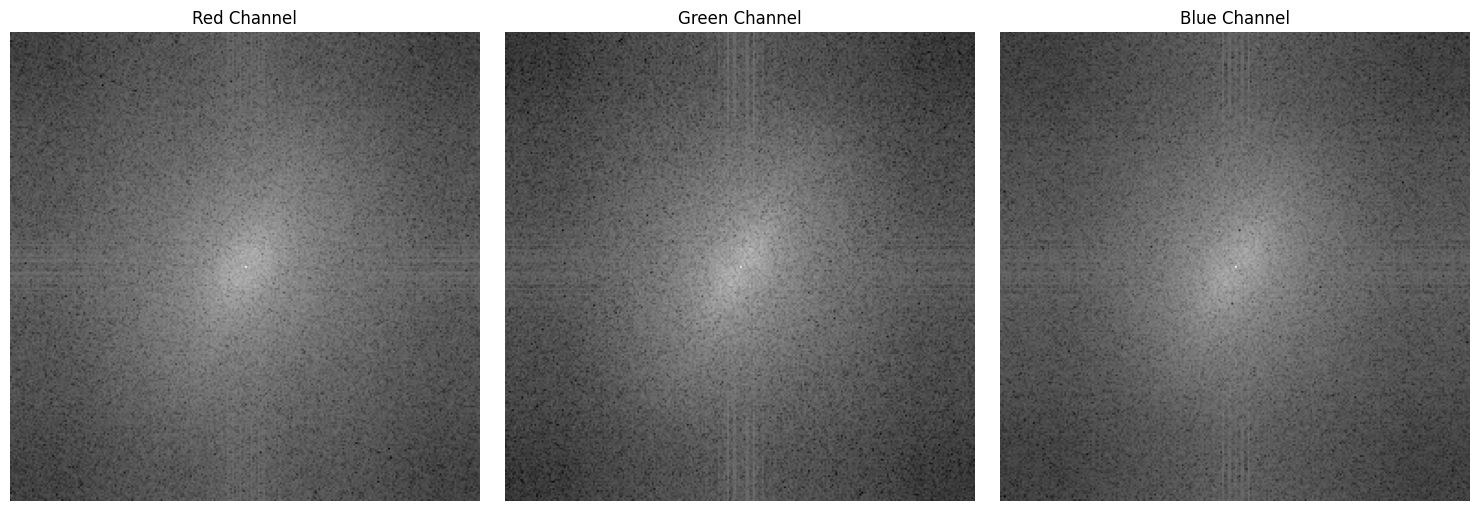

In [56]:
#test
#Display of the amplitude spectrum for RGB

def amplitude_spectrum_per_channel(img):
    """
    Computes the log-amplitude spectrum for each channel in a CHW image.

    Args:
        img (np.ndarray): Image in shape (C, H, W), float32 or uint8.

    Returns:
        List[np.ndarray]: Log-amplitude spectrum for each channel.
    """
    img = img.astype(np.float32)
    spectra = []

    for c in range(img.shape[0]):
        fft = np.fft.fft2(img[c])                 # FFT per channel
        fft_shift = np.fft.fftshift(fft)          # Shift low-freq to center
        amplitude = np.abs(fft_shift)
        log_amp = np.log1p(amplitude)             # log(1 + x) for stability
        spectra.append(log_amp)

    return spectra

# Apply to target image (CHW format)
spectra = amplitude_spectrum_per_channel(trg_img)

# Plot each channel's spectrum
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
channel_names = ['Red Channel', 'Green Channel', 'Blue Channel']

for i in range(3):
    axes[i].imshow(spectra[i], cmap='gray')
    axes[i].set_title(channel_names[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()
